### Import lib

In [142]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta

## Data Collection

### Define startdate and enddate

In [143]:
today = date.today()
d1 = today.strftime("%Y-%m-%d")
end_date = d1

d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2


### Get data from yahoo finance

In [144]:
data = yf.download('GOOG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
245 2024-10-07  169.139999  169.899994  164.130005  164.389999  164.389999   
246 2024-10-08  165.429993  166.100006  164.309998  165.699997  165.699997   
247 2024-10-09  164.854996  166.259995  161.119995  163.059998  163.059998   
248 2024-10-10  162.110001  164.311005  161.639999  163.179993  163.179993   
249 2024-10-11  163.330002  165.270004  162.500000  164.520004  164.520004   

       Volume  
245  14034700  
246  11723900  
247  19666400  
248  12900500  
249  10940500  


#### We only need 2 collumn ( Date and Close ) of original dataset:

In [145]:
data = data[["Date", "Close"]]
print(data.head())

        Date       Close
0 2023-10-16  140.490005
1 2023-10-17  140.990005
2 2023-10-18  139.279999
3 2023-10-19  138.979996
4 2023-10-20  136.740005


## EDA

### Google's Price moving forward

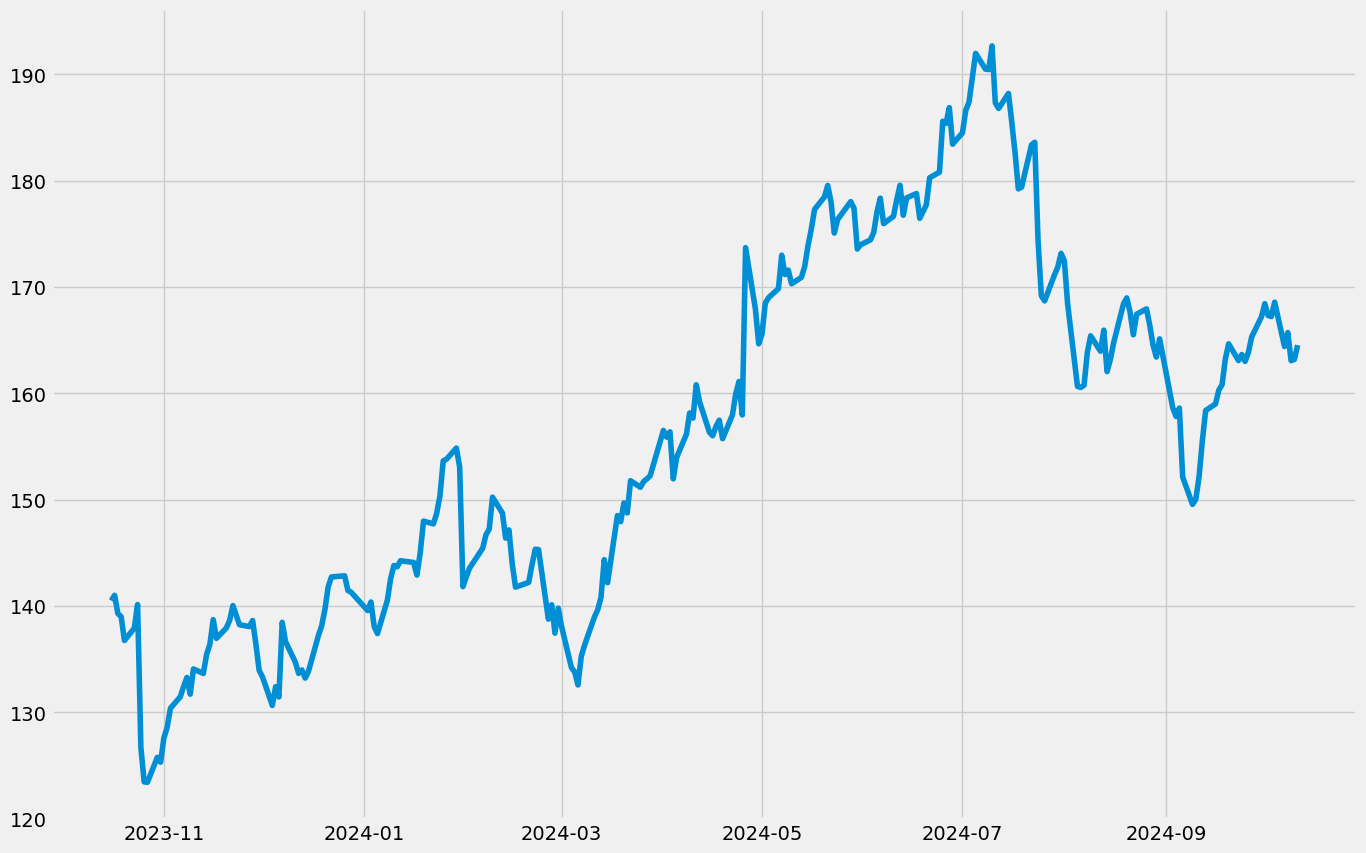

In [146]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

### Check data is seasonal or stationary

<Figure size 640x480 with 0 Axes>

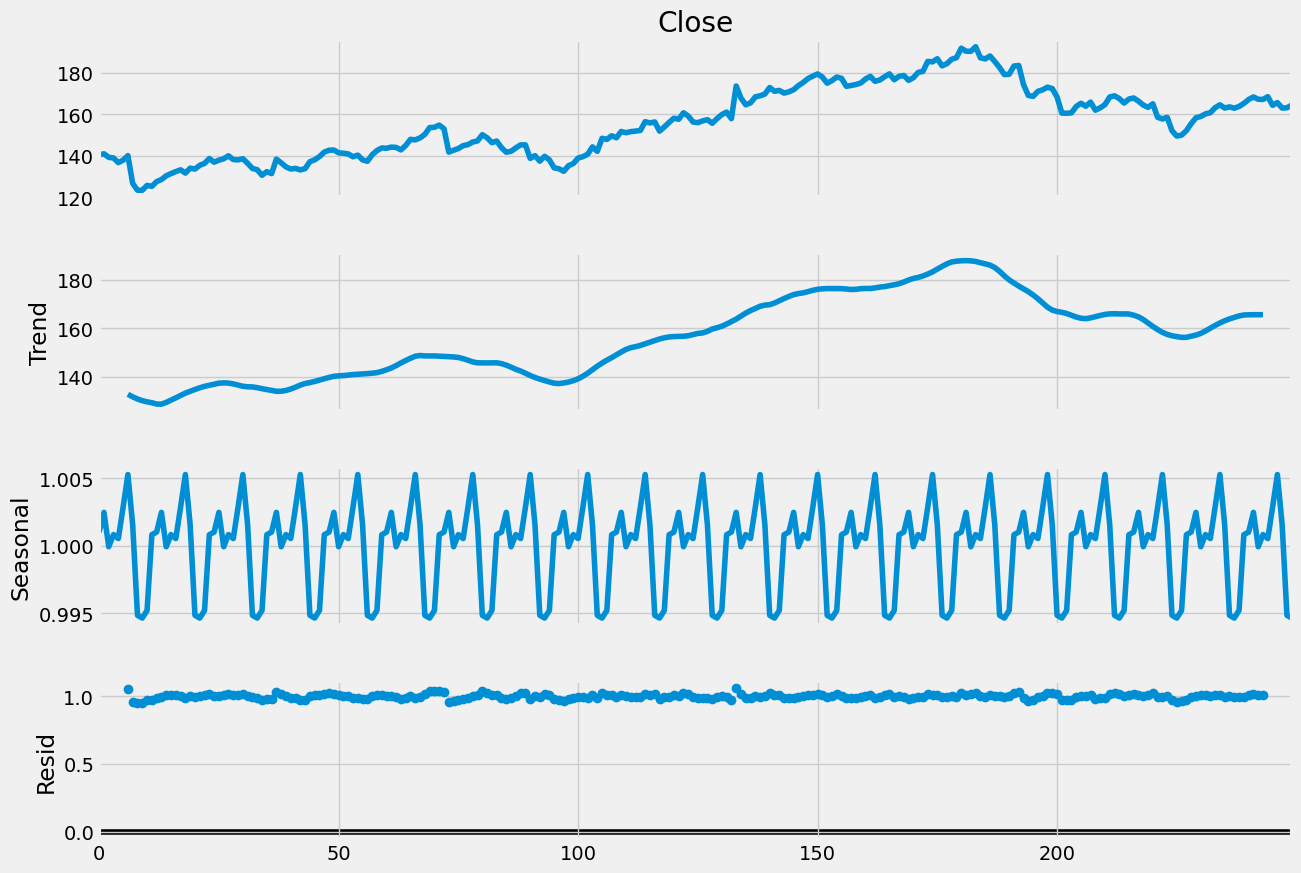

In [147]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], 
                            model='multiplicative', period = 12)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

So our data is seasonal -> use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data.

But before using the SARIMA model, we will use the ARIMA model. It will help you learn using both models.

## Model 

### Find q, d, q value by auto_arima function

In [148]:
import pmdarima as pm

model = pm.auto_arima(data['Close'], 
                       seasonal=True,    
                       stepwise=True,    
                       suppress_warnings=True)

print(model.summary())

p = model.order[0]
d = model.order[1]
q = model.order[2]

print(f'Optimal p: {p}')
print(f'Optimal d: {d}')
print(f'Optimal q: {q}')


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -601.632
Date:                Sun, 13 Oct 2024   AIC                           1205.264
Time:                        16:23:10   BIC                           1208.782
Sample:                             0   HQIC                          1206.680
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         7.3486      0.303     24.232      0.000       6.754       7.943
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               594.53
Prob(Q):                              0.83   Pr

#### Model

In [149]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))

model=model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  250
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -656.813
Date:                            Sun, 13 Oct 2024   AIC                           1315.627
Time:                                    16:23:10   BIC                           1319.095
Sample:                                         0   HQIC                          1317.025
                                            - 250                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        14.9521      0.888     16.845      0.000      13.212      16.692
Ljung-Box (L1) (Q):                

In [150]:

# Predictions on test data
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = model.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate metrics
mse = mean_squared_error(test['Close'], predictions)
mae = mean_absolute_error(test['Close'], predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 11.231961890862353
Mean Absolute Error: 2.4380965459785413


Forecasting in next 10 days:

In [151]:
forecasting = model.predict(len(data), len(data)+10)

<Axes: >

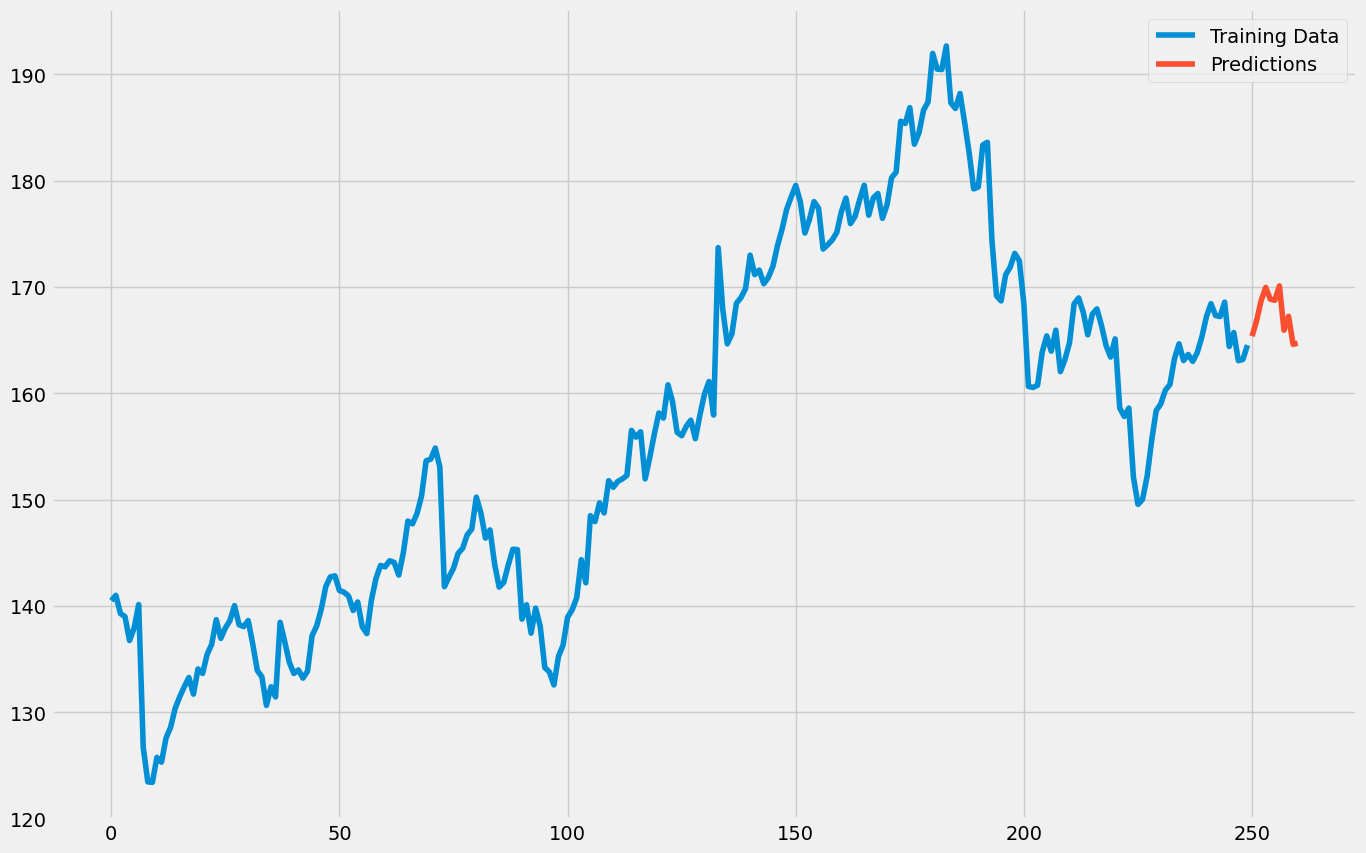

In [152]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
forecasting.plot(legend=True, label="Predictions")

### Find the p, d, and q values

#### Value of d

The value of d is either 0 or 1. If the data is stationary, we use 0, and if the data is seasonal, we use 1. So, in this case, we will use d = 1

#### Value of p

We can find the value of p by plotting the Partial Autocorrelation Function (PACF) of the Close column

<Figure size 1000x600 with 0 Axes>

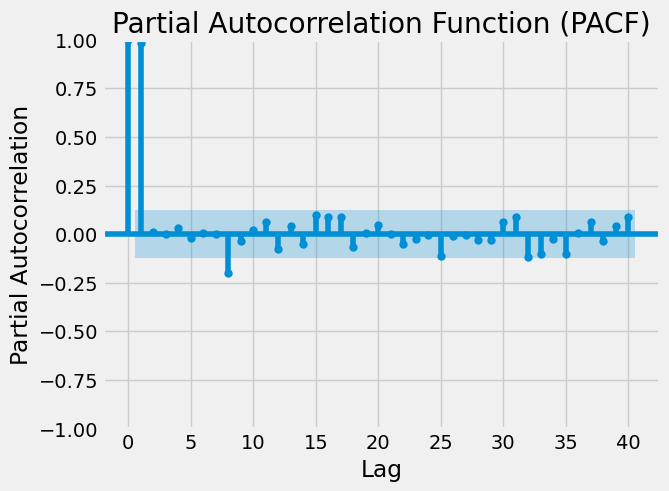

In [153]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 6))
plot_pacf(data["Close"], lags=40, method='ywm', alpha=0.05)  # Set lags as desired
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.show()

Two points are far away from all the points -> p = 2

#### Value of q

<Figure size 1000x600 with 0 Axes>

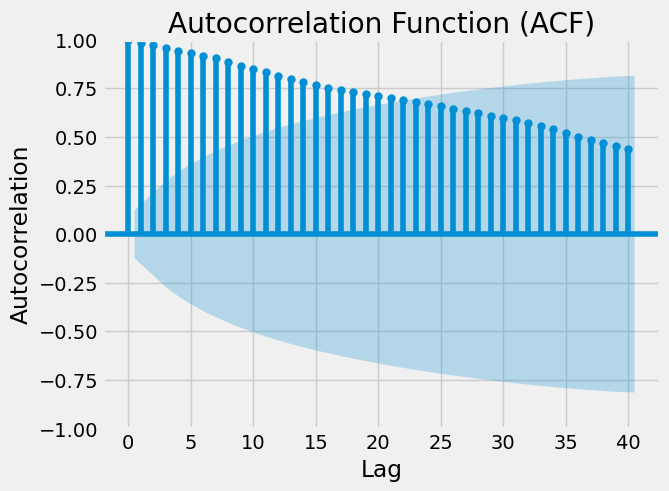

In [154]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'Close' is the column of interest
plt.figure(figsize=(10, 6))
plot_acf(data["Close"], lags=40, alpha=0.05)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()


The autocorrelation values are high and gradually decrease but remain outside the confidence interval until a very large lag. This indicates that the time series may be non-stationary, suggesting the need for differencing to make the series stationary before determining the value of q.

<Figure size 1000x500 with 0 Axes>

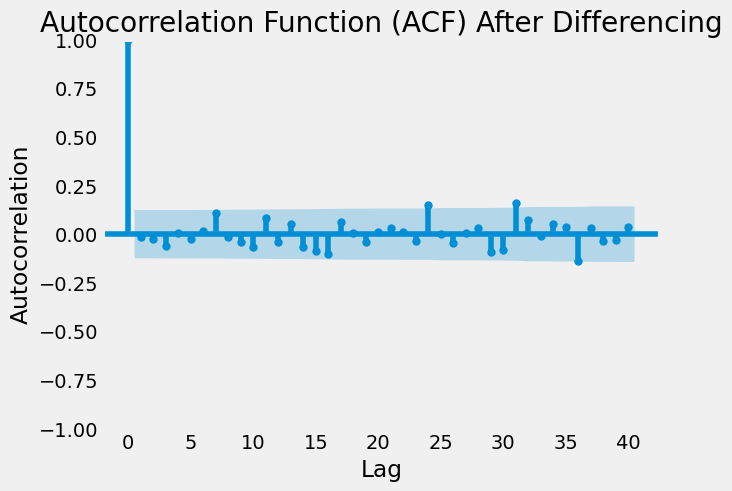

In [155]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

df_differenced  = data['Close'].diff().dropna()

plt.figure(figsize=(10, 5))
plot_acf(df_differenced .dropna(), lags=40)
plt.title('Autocorrelation Function (ACF) After Differencing')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

One points are far away from all the points -> q = 1

#### Model

We use SARIMA because data is seasonal

In [156]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(2, 1, 1),
                                seasonal_order=(2, 1, 1, 12))
model=model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  250
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -588.625
Date:                            Sun, 13 Oct 2024   AIC                           1191.249
Time:                                    16:23:13   BIC                           1215.526
Sample:                                         0   HQIC                          1201.034
                                            - 250                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5007      1.449      0.346      0.730      -2.339       3.340
ar.L2         -0.0260      0.088   

In [157]:
from sklearn.metrics import mean_squared_error
predictions = model.predict(len(data)-100, len(data)-1)
actual = data["Close"].values[len(data)-100:]

mse = mean_squared_error(actual, predictions)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 6.588603683676223


Forecasting in next 10 days:

In [158]:
forecasting = model.predict(len(data), len(data)+10)

<Axes: >

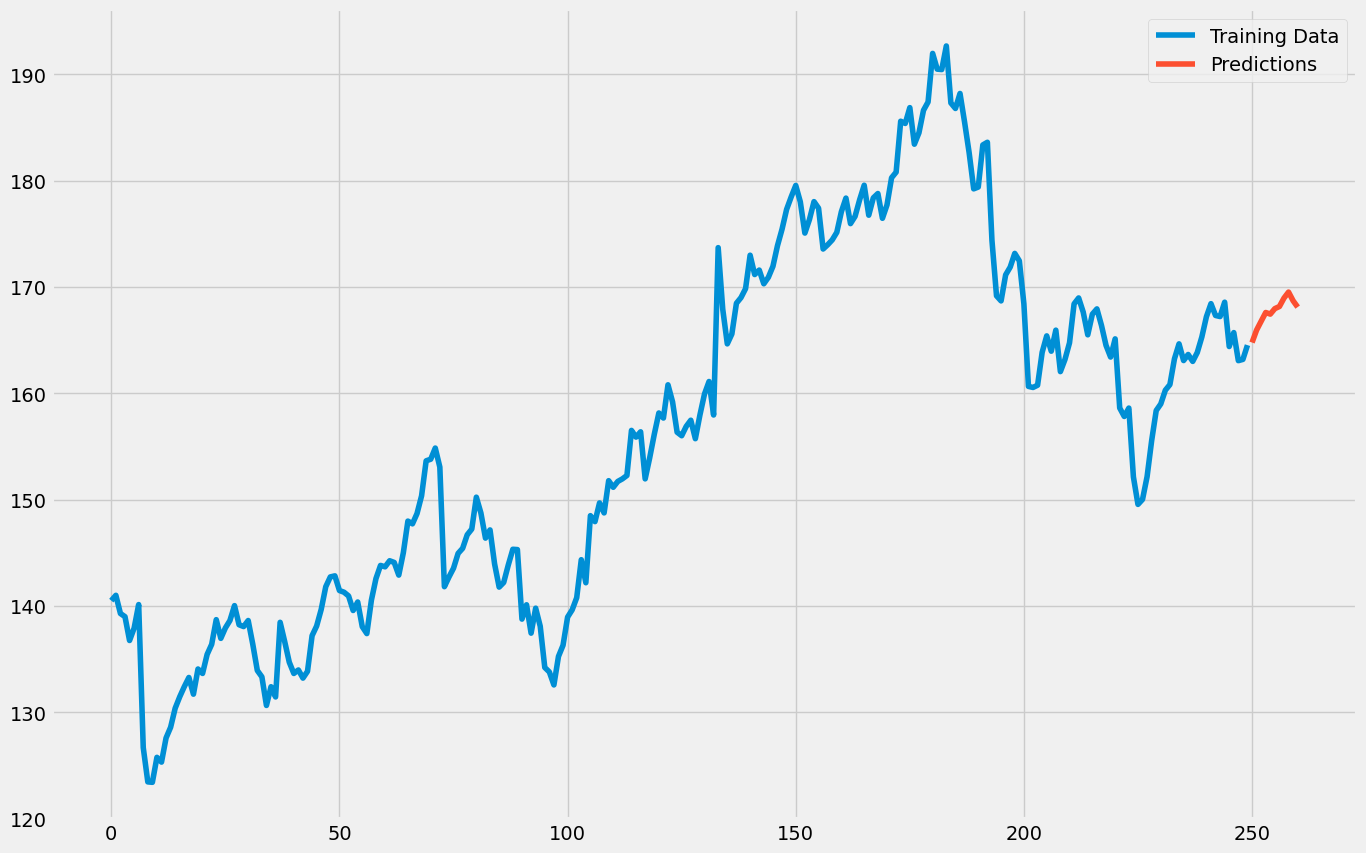

In [159]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
forecasting.plot(legend=True, label="Predictions")